# Scratch NN Part

In [ ]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Loading the CIFAR10 dataset
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Step 2: Preprocess and Split the Data
X_train = np.array([item[0].numpy().flatten() for item in trainset])
y_train = np.array([item[1] for item in trainset])

X_test = np.array([item[0].numpy().flatten() for item in testset])
y_test = np.array([item[1] for item in testset])

shuffle_idx = np.random.permutation(len(X_train))
X_train, y_train = X_train[shuffle_idx], y_train[shuffle_idx]

val_size = int(0.1 * len(X_train))
X_val, y_val = X_train[:val_size], y_train[:val_size]
X_train, y_train = X_train[val_size:], y_train[val_size:]

100%|██████████| 170498071/170498071 [00:05<00:00, 31828943.78it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
import numpy as np
import math

class NeuralNetwork:
    def __init__(self, layer_dimensions):
        self.layer_dimensions = layer_dimensions
        self.parameters = self.initialize_parameters(layer_dimensions)

    def initialize_parameters(self, layer_dimensions):
        parameters = {}
        for l in range(1, len(layer_dimensions)):
            parameters['W' + str(l)] = np.random.randn(layer_dimensions[l], layer_dimensions[l-1]) * 0.01
            parameters['b' + str(l)] = np.zeros((layer_dimensions[l], 1))
        return parameters

    def affineForward(self, A, W, b):
        Z = np.dot(W, A) + b
        cache = (A, W, b)
        return Z, cache

    def activationForward(self, A):
        return np.maximum(0, A), A

    def forwardPropagation(self, X):
        caches = []
        A = X
        L = len(self.layer_dimensions) - 1

        for l in range(1, L):
            A_prev = A
            W = self.parameters['W' + str(l)]
            b = self.parameters['b' + str(l)]
            Z, cache = self.affineForward(A_prev, W, b)
            A, activation_cache = self.activationForward(Z)
            caches.append((cache, activation_cache))

        # Output layer (no activation)
        W = self.parameters['W' + str(L)]
        b = self.parameters['b' + str(L)]
        AL, cache = self.affineForward(A, W, b)
        caches.append((cache, None))

        return AL, caches

    def costFunction(self, AL, y):
        m = y.shape[1]
        epsilon = 1e-10
        AL = np.clip(AL, epsilon, 1 - epsilon)
        cost = (-1 / m) * np.sum(np.multiply(y, np.log(AL)) + np.multiply(1 - y, np.log(1 - AL)))
        cost = np.squeeze(cost)
        return cost

    def activationBackward(self, dA, cache):
        Z = cache
        dZ = np.array(dA, copy=True)
        dZ[Z <= 0] = 0
        return dZ

    def affineBackward(self, dA, cache):
        A_prev, W, b = cache
        m = A_prev.shape[1]
        dW = (1 / m) * np.dot(dA, A_prev.T)
        db = (1 / m) * np.sum(dA, axis=1, keepdims=True)
        dA_prev = np.dot(W.T, dA)
        return dA_prev, dW, db

    def backwardPropagation(self, dAL, Y, caches):
        grads = {}
        L = len(caches) - 1
        m = dAL.shape[1]
        # Y = Y.reshape(dAL.shape)

        current_cache, _ = caches[L]
        grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = self.affineBackward(dAL, current_cache)

        for l in reversed(range(L-1)):
            current_cache, activation_cache = caches[l]
            dA_prev_temp, dW_temp, db_temp = self.affineBackward(self.activationBackward(grads["dA" + str(l+1)], activation_cache), current_cache)
            grads["dA" + str(l)] = dA_prev_temp
            grads["dW" + str(l + 1)] = dW_temp
            grads["db" + str(l + 1)] = db_temp

        return grads

    def updateParameters(self, grads, alpha):
        L = len(self.parameters) // 2
        for l in range(L-1):
            self.parameters["W" + str(l+1)] -= alpha * grads["dW" + str(l+1)]
            self.parameters["b" + str(l+1)] -= alpha * grads["db" + str(l+1)]

    def train(self, X_train, X_val, y_train, y_val, iters, alpha, batch_size):
        for i in range(1, iters+1):
            minibatches = self.random_mini_batches(X_train, y_train, batch_size)
            for minibatch in minibatches:
                (minibatch_X, minibatch_Y) = minibatch
                AL, caches = self.forwardPropagation(minibatch_X)
                cost = self.costFunction(AL, minibatch_Y)
                grads = self.backwardPropagation(AL, minibatch_Y, caches)
                self.updateParameters(grads, alpha)

            if i % 50 == 0:
                train_preds = self.predict(X_train)
                val_preds = self.predict(X_val)
                train_acc = np.mean((train_preds == y_train))
                val_acc = np.mean((val_preds == y_val))
                print(f"Iteration {i}: Training Accuracy = {train_acc}, Validation Accuracy = {val_acc}")

    def random_mini_batches(self, X, Y, mini_batch_size=64, seed=0):
        m = X.shape[1]
        mini_batches = []
        np.random.seed(seed)

        permutation = list(np.random.permutation(m))
        shuffled_X = X[:, permutation]
        shuffled_Y = Y[:, permutation].reshape((1, m))

        num_complete_minibatches = m // mini_batch_size

        for k in range(num_complete_minibatches):
            mini_batch_X = shuffled_X[:, k * mini_batch_size:(k + 1) * mini_batch_size]
            mini_batch_Y = shuffled_Y[:, k * mini_batch_size:(k + 1) * mini_batch_size]

            mini_batch = (mini_batch_X, mini_batch_Y)
            mini_batches.append(mini_batch)

        if m % mini_batch_size != 0:
            mini_batch_X = shuffled_X[:, num_complete_minibatches * mini_batch_size:]
            mini_batch_Y = shuffled_Y[:, num_complete_minibatches * mini_batch_size:]

            mini_batch = (mini_batch_X, mini_batch_Y)
            mini_batches.append(mini_batch)

        return mini_batches

    def predict(self, X_new):
        AL, _ = self.forwardPropagation(X_new)
        predictions = np.argmax(AL, axis=0)
        return predictions


Iteration 50: Training Accuracy = 0.09993333333333333, Validation Accuracy = 0.1006
Iteration 100: Training Accuracy = 0.10004444444444445, Validation Accuracy = 0.0996
Iteration 150: Training Accuracy = 0.10004444444444445, Validation Accuracy = 0.0996
Iteration 200: Training Accuracy = 0.10004444444444445, Validation Accuracy = 0.0996
Iteration 250: Training Accuracy = 0.10004444444444445, Validation Accuracy = 0.0996
Iteration 300: Training Accuracy = 0.10004444444444445, Validation Accuracy = 0.0996
Iteration 350: Training Accuracy = 0.10004444444444445, Validation Accuracy = 0.0996
Iteration 400: Training Accuracy = 0.10004444444444445, Validation Accuracy = 0.0996
Iteration 450: Training Accuracy = 0.10004444444444445, Validation Accuracy = 0.0996
Iteration 500: Training Accuracy = 0.10004444444444445, Validation Accuracy = 0.0996


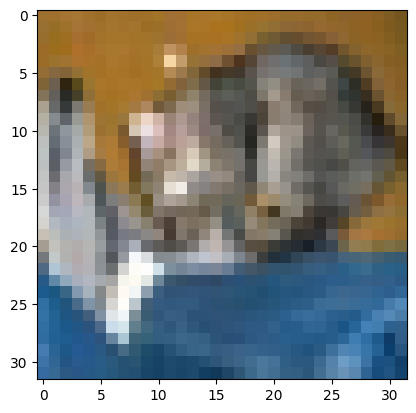

Predicted Label: 0 	 Actual Label: 3


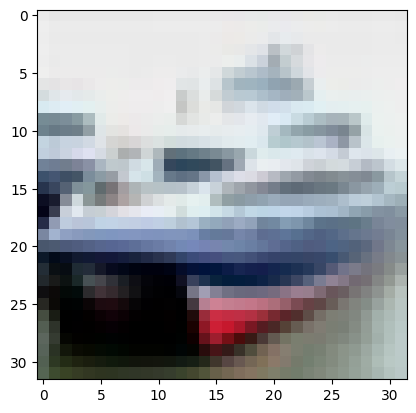

Predicted Label: 0 	 Actual Label: 8


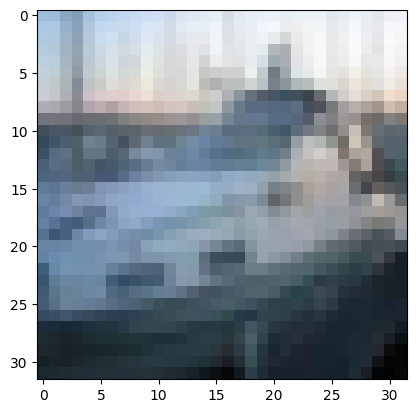

Predicted Label: 0 	 Actual Label: 8


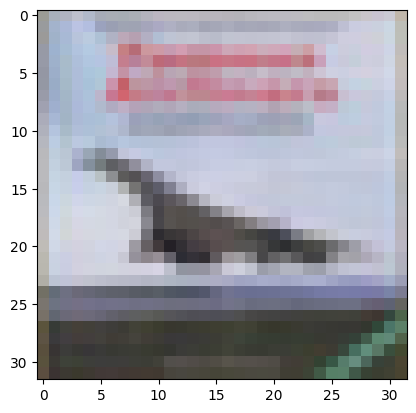

Predicted Label: 0 	 Actual Label: 0


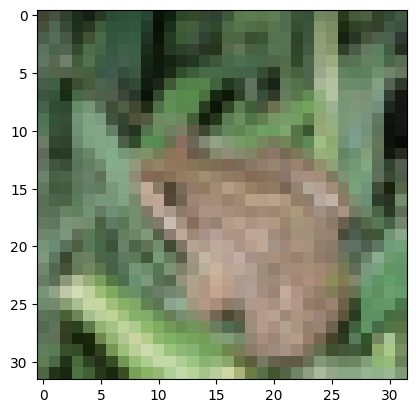

Predicted Label: 0 	 Actual Label: 6


In [ ]:
# Step 3: Define and Train the Neural Network

# Define the layer dimensions for the neural network
layer_dimensions = [3072, 10, 10, 10, 10]

# Create an instance of NeuralNetwork
net = NeuralNetwork(layer_dimensions)

# Train the network
net.train(X_train.T, X_val.T, y_train.reshape(1, -1), y_val.reshape(1, -1), iters=500, alpha=0.01, batch_size=64)

# Step 4: Making Predictions
predictions = net.predict(X_test.T)

# Step 5: Displaying Images and Predicted Labels
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

for i in range(5):
    imshow(torch.Tensor(X_test[i].reshape(3, 32, 32)))
    plt.show()
    print(f'Predicted Label: {predictions[i]} \t Actual Label: {y_test[i]}')

# CNN

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

# Define the CNN architecture
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.norm1 = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.norm2 = nn.BatchNorm2d(32)
        self.fc1 = nn.Linear(32 * 8 * 8, 128)
        self.dropout = nn.Dropout(0.5)  # Add dropout layer with 50% dropout rate
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(self.norm1(torch.relu(self.conv1(x))))
        x = self.pool(self.norm2(torch.relu(self.conv2(x))))
        x = x.view(-1, 32 * 8 * 8)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)  # Apply dropout
        x = self.fc2(x)
        return x

In [ ]:
# Step 2: Define the data augmentation and preprocessing
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [ ]:
# Step 3: Load CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# Step 4: Initialize the model, loss function, and optimizer
net = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Step 5: Train the model
for epoch in range(100):  # Adjust the number of epochs as needed
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Calculate training accuracy and loss
    train_accuracy = 100 * correct_train / total_train
    avg_loss = running_loss / len(trainloader)

    # Task:  1.7
    # Evaluate on validation se6
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    # Calculate validation accuracy
    val_accuracy = 100 * correct_val / total_val

    print(f'Epoch {epoch+1}, Loss: {avg_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {val_accuracy:.2f}%')

Epoch 1, Loss: 1.7551, Training Accuracy: 36.00%, Validation Accuracy: 43.17%
Epoch 2, Loss: 1.4787, Training Accuracy: 46.35%, Validation Accuracy: 49.68%
Epoch 3, Loss: 1.3714, Training Accuracy: 50.52%, Validation Accuracy: 52.26%
Epoch 4, Loss: 1.3007, Training Accuracy: 53.30%, Validation Accuracy: 54.23%
Epoch 5, Loss: 1.2452, Training Accuracy: 55.19%, Validation Accuracy: 56.26%
Epoch 6, Loss: 1.2030, Training Accuracy: 56.94%, Validation Accuracy: 57.00%
Epoch 7, Loss: 1.1641, Training Accuracy: 58.74%, Validation Accuracy: 59.50%
Epoch 8, Loss: 1.1367, Training Accuracy: 59.57%, Validation Accuracy: 59.65%
Epoch 9, Loss: 1.1047, Training Accuracy: 60.85%, Validation Accuracy: 60.53%
Epoch 10, Loss: 1.0958, Training Accuracy: 61.14%, Validation Accuracy: 61.05%
Epoch 11, Loss: 1.0735, Training Accuracy: 61.97%, Validation Accuracy: 61.68%
Epoch 12, Loss: 1.0601, Training Accuracy: 62.28%, Validation Accuracy: 62.61%
Epoch 13, Loss: 1.0409, Training Accuracy: 63.16%, Validation

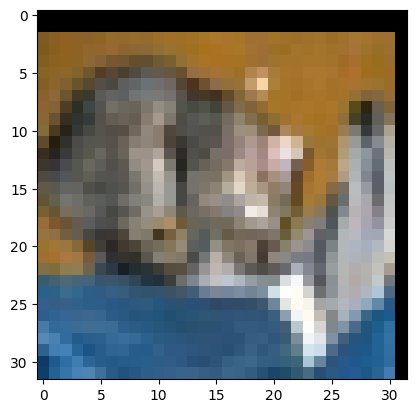

Predicted Label: 3, Actual Label: 3


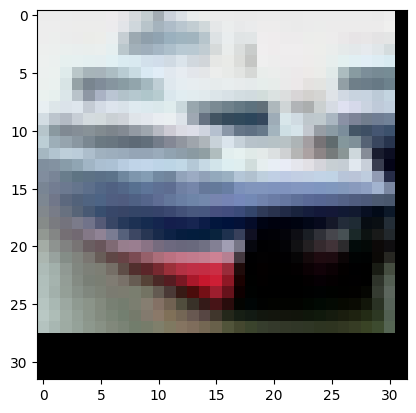

Predicted Label: 1, Actual Label: 8


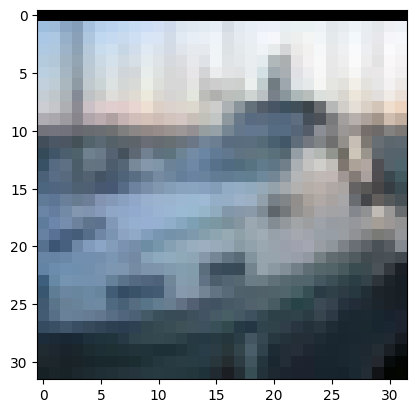

Predicted Label: 1, Actual Label: 8


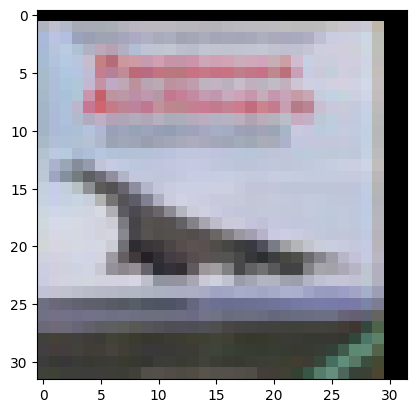

Predicted Label: 1, Actual Label: 0


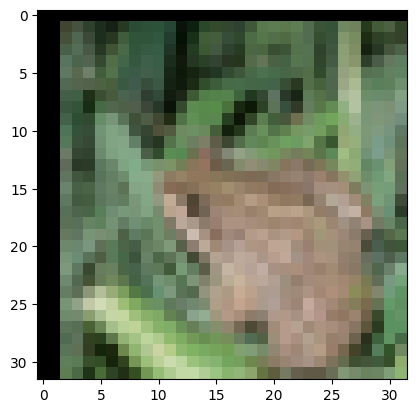

Predicted Label: 8, Actual Label: 6


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define a function to unnormalize and display images
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Display some test images and their predicted labels
for i in range(5):  # Display 5 images
    image, label = testset[i]
    imshow(image)
    outputs = net(image.unsqueeze(0))  # Make prediction
    _, predicted = torch.max(outputs, 1)
    print(f'Predicted Label: {predicted.item()}, Actual Label: {label}')

In [ ]:
# Define the CNN architecture
class CNN2(nn.Module):
    def __init__(self):
        super(CNN2, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.norm1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=2)
        self.norm2 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64 * 8 * 8, 512)
        self.dropout = nn.Dropout(0.3)  # Add dropout layer with 30% dropout rate
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(self.norm1(torch.relu(self.conv1(x))))
        x = self.pool(self.norm2(torch.relu(self.conv2(x))))
        x = x.view(-1, 64 * 8 * 8)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)  # Apply dropout
        x = self.fc2(x)
        return x

In [ ]:
# Step 4: Initialize the model, loss function, and optimizer
net_2 = CNN2()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net_2.parameters(), lr=0.001, momentum=0.9)


# Step 5: Train the model
for epoch in range(25):  # Adjust the number of epochs as needed
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = net_2(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Calculate training accuracy and loss
    train_accuracy = 100 * correct_train / total_train
    avg_loss = running_loss / len(trainloader)

    # Evaluate on validation set
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net_2(images)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    # Calculate validation accuracy
    val_accuracy = 100 * correct_val / total_val

    print(f'Epoch {epoch+1}, Loss: {avg_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {val_accuracy:.2f}%')

Epoch 1, Loss: 1.5600, Training Accuracy: 43.30%, Validation Accuracy: 51.21%
Epoch 2, Loss: 1.2480, Training Accuracy: 55.18%, Validation Accuracy: 57.40%
Epoch 3, Loss: 1.1056, Training Accuracy: 60.52%, Validation Accuracy: 61.53%
Epoch 4, Loss: 1.0148, Training Accuracy: 64.07%, Validation Accuracy: 64.07%
Epoch 5, Loss: 0.9510, Training Accuracy: 66.36%, Validation Accuracy: 66.25%
Epoch 6, Loss: 0.9008, Training Accuracy: 68.19%, Validation Accuracy: 68.13%
Epoch 7, Loss: 0.8556, Training Accuracy: 69.96%, Validation Accuracy: 69.49%
Epoch 8, Loss: 0.8160, Training Accuracy: 71.43%, Validation Accuracy: 70.18%
Epoch 9, Loss: 0.7883, Training Accuracy: 72.18%, Validation Accuracy: 71.60%
Epoch 10, Loss: 0.7614, Training Accuracy: 73.34%, Validation Accuracy: 72.12%
Epoch 11, Loss: 0.7361, Training Accuracy: 74.27%, Validation Accuracy: 72.35%
Epoch 12, Loss: 0.7181, Training Accuracy: 74.87%, Validation Accuracy: 73.38%
Epoch 13, Loss: 0.6961, Training Accuracy: 75.58%, Validation

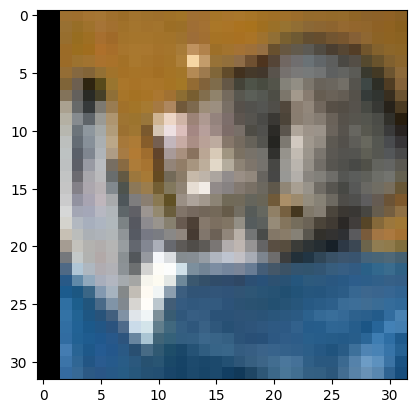

Predicted Label: 3, Actual Label: 3


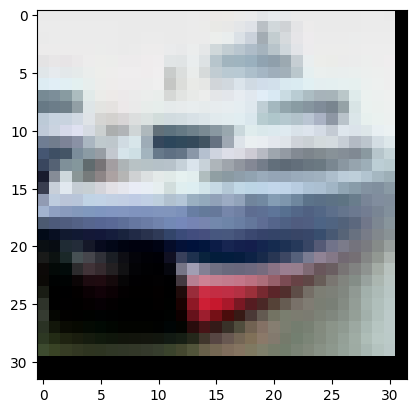

Predicted Label: 8, Actual Label: 8


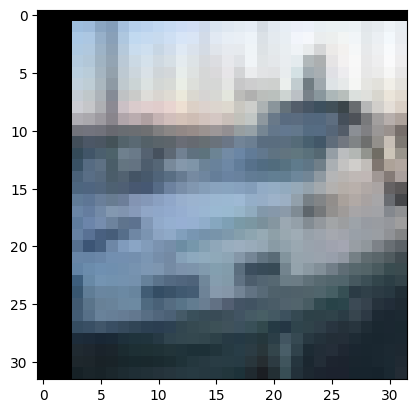

Predicted Label: 0, Actual Label: 8


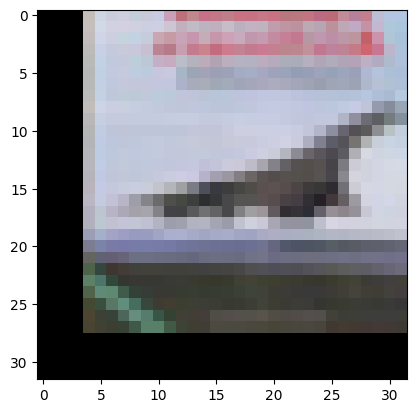

Predicted Label: 8, Actual Label: 0


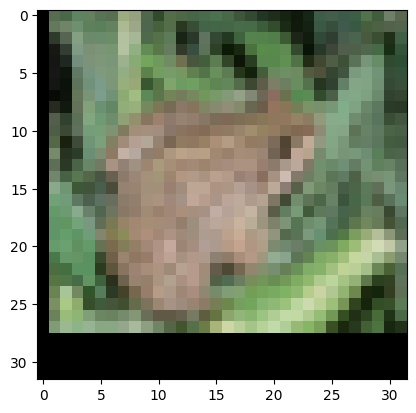

Predicted Label: 6, Actual Label: 6


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define a function to unnormalize and display images
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Display some test images and their predicted labels
for i in range(5):  # Display 5 images
    image, label = testset[i]
    imshow(image)
    outputs = net_2(image.unsqueeze(0))  # Make prediction
    _, predicted = torch.max(outputs, 1)
    print(f'Predicted Label: {predicted.item()}, Actual Label: {label}')